# NN debug

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/04-debug/homework.ipynb)

В этой тетрадке мы рассмотрим несколько проблем с обучением сеток и способы их решения.

*Лучше решать эту домашку в колабе*

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torch.utils.tensorboard import SummaryWriter

import gdown

from copy import deepcopy


In [5]:
%load_ext tensorboard

# Data

Для обучения сеток мы будем использовать MNIST.

Качаем архив [Google Drive](https://drive.google.com/file/d/1xo-AIG2E6cTZbWGti1A5lp5FDtf4aHx_/view?usp=sharing). 
Его структура следующая:
- /
    - /train.csv
    - /val.csv
    - /train/{image_name}.png
    - /val/{image_name}.png

CSV файлы содержат название файла и его лейбл: image_name, label.

Распакуйте архив в текущую папку:
`unzip -q ./mnist_data2.zip -d ./`

In [6]:
class MNISTDataset(Dataset):
    def __init__(self, images_dir_path: str,
                 description_csv_path: str):
        super().__init__()
        
        self.images_dir_path = images_dir_path
        self.description_df = pd.read_csv(description_csv_path,
                                           dtype={'image_name': str, 'label': int})

    def __len__(self):
        return len(self.description_df)
    
    def __getitem__(self, index):
        img_name, label = self.description_df.iloc[index, :]
        
        img_path = Path(self.images_dir_path, f'{img_name}.png')
        img = self._read_img(img_path)
        
        return dict(sample=img, label=label)
    
    @staticmethod
    def _read_img(img_path: Path):
        img = cv2.imread(str(img_path.resolve()))
        img = img.astype(np.float32)
        img = np.transpose(img, (2, 0, 1))
        
        return img

## Задание 1
**(0.4 балла)** Запустите обучение сети в ячейках ниже. За 10 эпох метрика на валидации вырастает всего до ~0.15.

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку в коде и объясните ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке перед следующим заданием
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [12]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)
        self.cache = self.cache_states()


    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=False, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)

    def find_lr(self, min_lr: float = 1e-8,
                max_lr: float = 1e-1,
                num_lrs: int = 50,
                smooth_beta: float = 0.8,
                return_ = True) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)


        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()
        
        plt.figure(figsize=(16, 8))
        plt.plot(logs['lr'], logs['loss'])
        plt.xscale('log')
        plt.grid()
        plt.title('LR Range Test')
        plt.show()

        if return_:
            return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

In [10]:
!gdown https://drive.google.com/u/0/uc?id=1xo-AIG2E6cTZbWGti1A5lp5FDtf4aHx_ # через wget не получалось 

Downloading...
From: https://drive.google.com/u/0/uc?id=1xo-AIG2E6cTZbWGti1A5lp5FDtf4aHx_
To: /content/mnist_data2.zip
36.8MB [00:00, 101MB/s] 


In [11]:
!unzip -q ./mnist_data2.zip -d ./

In [13]:
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=1e-2)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='./tboard_logs/exp1_1')

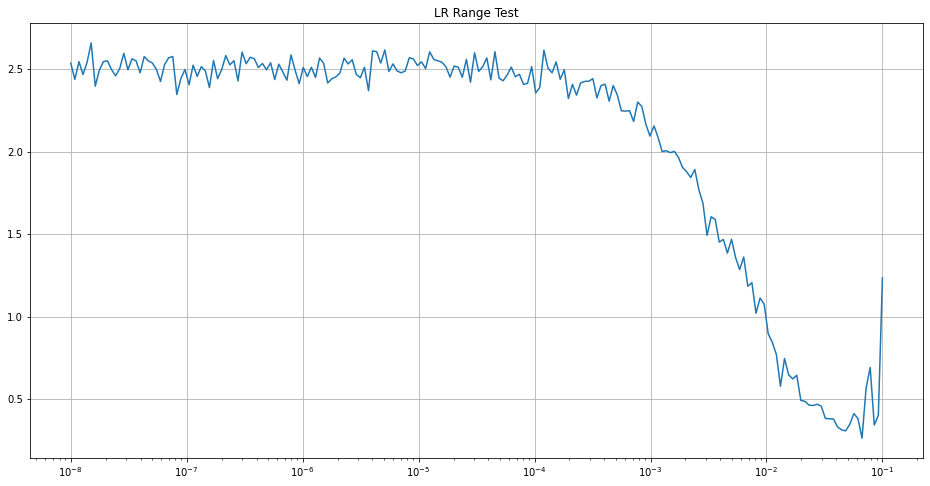

In [8]:
trainer.find_lr(return_=False,  num_lrs=200) # хм, вроде lr оптимальный по дефолту

In [14]:
trainer.train(10)

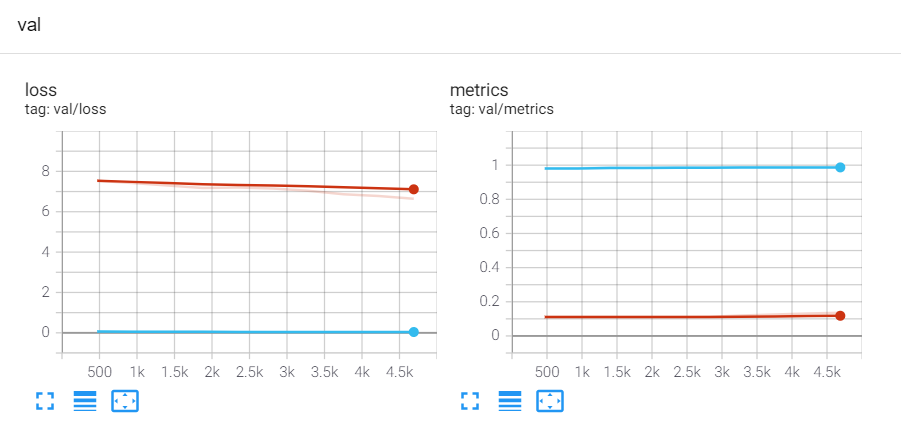

Просто сделал шафл... Он очень важен, ведь с ним бачи в эпохах будут разные, что помогает избежать недо/переобучения. В нам же еще случае данные лежат классами по бачам. Давайте проверим: 

In [21]:
for i in range(10):
  print(mnist_train[i]['label']) # что и требовалось доказать. Правильный класс ниже

0
0
0
0
0
0
0
0
0
0


In [22]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)
        self.cache = self.cache_states()


    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)

    def find_lr(self, min_lr: float = 1e-8,
                max_lr: float = 1e-1,
                num_lrs: int = 50,
                smooth_beta: float = 0.8,
                return_ = True) -> dict:
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None
        model, optimizer = self.model, self.optimizer
        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)

        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)


        logs.update({key: np.array(val) for key, val in logs.items()})
        self.rollback_states()
        
        plt.figure(figsize=(16, 8))
        plt.plot(logs['lr'], logs['loss'])
        plt.xscale('log')
        plt.grid()
        plt.title('LR Range Test')
        plt.show()

        if return_:
            return logs

    def cache_states(self):
        cache_dict = {'model_state': deepcopy(self.model.state_dict()),
                      'optimizer_state': deepcopy(self.optimizer.state_dict())}

        return cache_dict

    def rollback_states(self):
        self.model.load_state_dict(self.cache['model_state'])
        self.optimizer.load_state_dict(self.cache['optimizer_state'])

## Задание 2
**(0.2 балла)** Запустите обучение сети в ячейках ниже. За 10 эпох сетка не покажет качества выше случайного угадывания.

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку в коде и объясните почему найденная ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке перед следующим заданием
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [23]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)

In [27]:
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=10e-2, weight_decay=9e-1) # смущает кривой лернинг рейт! # ну и L2 пеналти

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='./tboard_logs/exp2')

In [28]:
trainer.train(10)

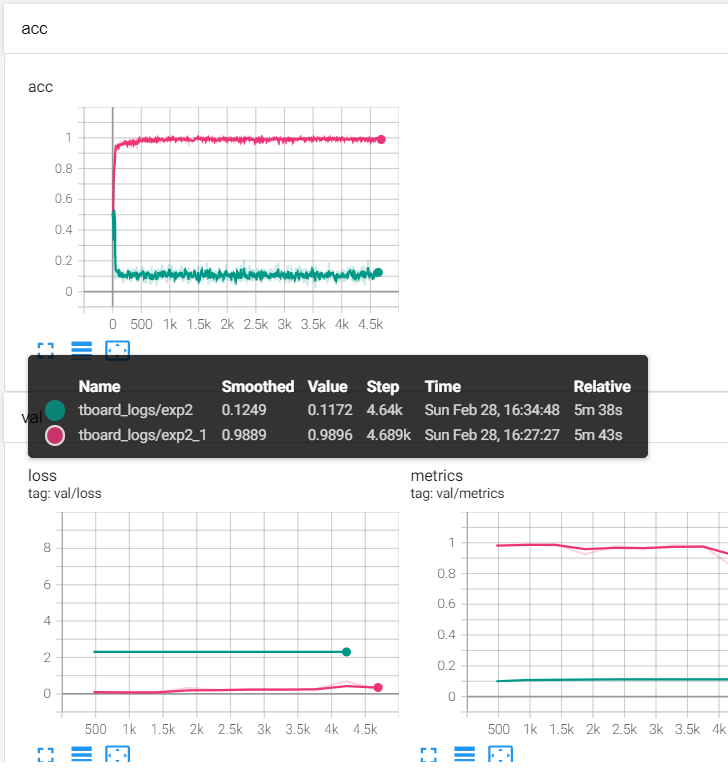

In [ ]:
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
opt = optim.SGD(model.parameters(), lr=1e-2, weight_decay=9e-2) # смущает кривой лернинг рейт! # ну и L2 пеналти

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='./tboard_logs/exp2_1')

## Задание 3
**(0.4 балла)** Запустите обучение сети в ячейках ниже. В сети будут использоваться предобученные параметры, которые должны были помочь выдавать качество около 1. Однако, за 5 эпох сетка не выдаст качество, которое мы ожидали.

Перед запуском ячеек скачайте используемое состояние модели [pretrained_model.pt](https://drive.google.com/file/d/1JITAz1L8mWpTGany84YMYKIhzVgsBf_9/view?usp=sharing).

*Вопросы:*
1. Почему сетка так плохо учится?
1. Найдите ошибку и объясните почему найденная ошибка вызывает подобное поведение в обучении?

*Requirements:*
1. Напишите ответы в markdown ячейке после ячейки с тензорбордом.
1. В следующей ячейке (после вашего ответа) вставьте код с исправлением ошибки.

In [12]:
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = resnet18()
        self.net.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.net(x)

    def compute_all(self, batch):
        x = batch['sample'] / 255.0
        y = batch['label']
        logits = self.net(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


class Trainer:
    def __init__(self, model: nn.Module,
                 optimizer,
                 train_dataset: Dataset,
                 val_dataset: Dataset,
                 tboard_log_dir: str,
                 batch_size: int = 128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.log_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            val_losses, val_metrics_list = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                val_metrics_list.append(details['acc'].item())

            val_loss, val_metrics = np.mean(val_losses), np.mean(val_metrics_list)
            self.log_writer.add_scalar('val/loss', val_loss, global_step=self.global_step)
            self.log_writer.add_scalar('val/metrics', val_metrics, global_step=self.global_step)

In [13]:
!gdown https://drive.google.com/u/0/uc?id=1JITAz1L8mWpTGany84YMYKIhzVgsBf_9 # через wget не получалось 

Downloading...
From: https://drive.google.com/u/0/uc?id=1JITAz1L8mWpTGany84YMYKIhzVgsBf_9
To: /content/pretrained_model.pt
44.8MB [00:00, 143MB/s]


In [49]:
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
model_sate_path = 'pretrained_model.pt'
model.load_state_dict(torch.load(model_sate_path, map_location='cpu'))

opt = optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='./tboard_logs/exp3_1')

In [50]:
trainer.train(5)

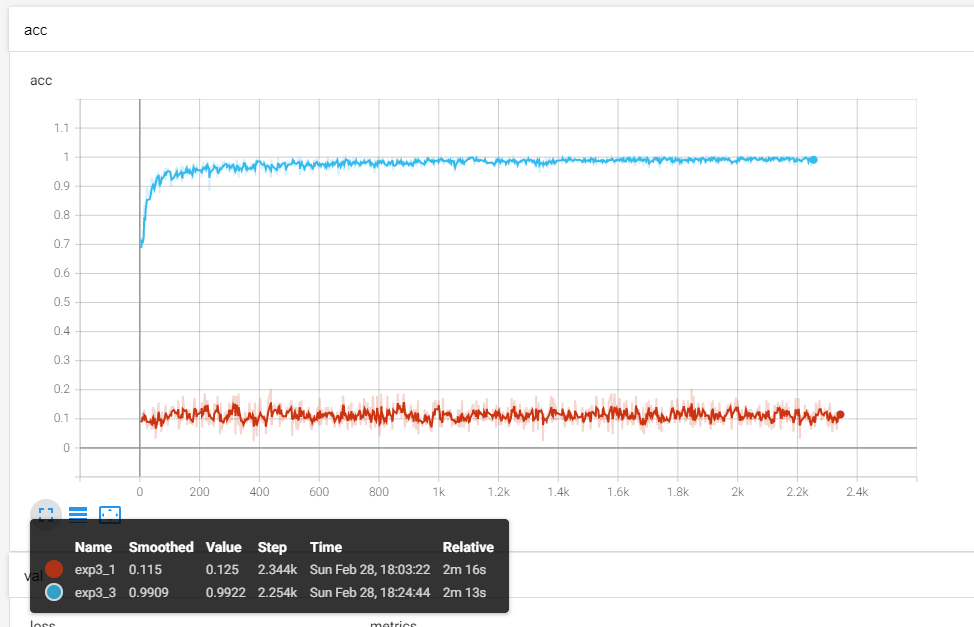

In [27]:
model

ResNet18(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [46]:
for i in range(len(list(model.parameters()))):
  if list(model.parameters())[i].sum() == 0):
    

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, dev

In [29]:
all_grads = []

for name, param in model.named_parameters():
    x = param.data.cpu().numpy().reshape(-1)
    x = np.sqrt((x ** 2).sum())
    t = param.grad.data.cpu().numpy().reshape(-1)
    all_grads.append(t)
    t = np.sqrt((t ** 2).sum())
    print(name, x, t)


x = np.concatenate(all_grads)

net.conv1.weight 2.5787401 0.0
net.bn1.weight 8.003414 0.0
net.bn1.bias 0.021599425 0.0
net.layer1.0.conv1.weight 11.346988 0.0
net.layer1.0.bn1.weight 8.000002 0.0
net.layer1.0.bn1.bias 0.02050818 0.0
net.layer1.0.conv2.weight 11.363903 0.0
net.layer1.0.bn2.weight 8.001356 0.0
net.layer1.0.bn2.bias 0.017316088 0.0
net.layer1.1.conv1.weight 11.2974615 0.0
net.layer1.1.bn1.weight 8.0 0.0
net.layer1.1.bn1.bias 0.018261585 0.0
net.layer1.1.conv2.weight 11.379153 0.0
net.layer1.1.bn2.weight 7.995271 0.0
net.layer1.1.bn2.bias 0.010944006 0.0
net.layer2.0.conv1.weight 0.0 0.0
net.layer2.0.bn1.weight 0.0 0.0
net.layer2.0.bn1.bias 0.0 0.0
net.layer2.0.conv2.weight 0.0 0.0
net.layer2.0.bn2.weight 0.0 0.0
net.layer2.0.bn2.bias 0.0 0.0
net.layer2.0.downsample.0.weight 0.0 0.0
net.layer2.0.downsample.1.weight 0.0 0.0
net.layer2.0.downsample.1.bias 0.0 0.0
net.layer2.1.conv1.weight 15.96789 0.0
net.layer2.1.bn1.weight 11.313707 0.0
net.layer2.1.bn1.bias 175056.61 11.983034
net.layer2.1.conv2.weight

Можно заметить, что дело все в нулевых подряд идущих слоях, которые дают градиенту затухнуть. По такими денсам мы пробегаемся и бахаем там равномерное распределение. Да, это нелогично, но проблему эту решает.

In [ ]:
mnist_train = MNISTDataset(images_dir_path='./mnist_data/train/',
                           description_csv_path='./mnist_data/train.csv')
mnist_val = MNISTDataset(images_dir_path='./mnist_data/val/',
                         description_csv_path='./mnist_data/val.csv')

model = ResNet18()
model_sate_path = 'pretrained_model.pt'
model.load_state_dict(torch.load(model_sate_path, map_location='cpu'))


for param in model.parameters(): # нужно такую штуку сделать
  if param.sum() == 0:
    param.data.uniform_(0,1)

opt = optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer(model=model, optimizer=opt, train_dataset=mnist_train,
                  val_dataset=mnist_val, tboard_log_dir='./tboard_logs/exp3_3')